### reference
 - https://publikationen.bibliothek.kit.edu/1000129520
 - https://github.com/2Obe/BSData
 - https://www.sciencedirect.com/science/article/pii/S2352340921009185?via%3Dihub

In [1]:
# 基本ライブラリ
import base64
import gc
import glob
import io
import json
import os
import pathlib
import pickle
import random
import sys
import warnings

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ディープラーニング用のライブラリ
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# データ前処理、拡張用のライブラリ
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    LambdaLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)
from torch.utils.data import DataLoader, Dataset

# プログレスバーのライブラリ
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

# 画像処理用のライブラリ
import cv2
import imageio

# アノテーション用のライブラリ
import labelme

# セグメンテーション用のライブラリ
import segmentation_models_pytorch as smp

# warning設定
import sklearn.exceptions
from labelme import utils
from PIL import Image, ImageDraw

# 評価指標計算用のライブラリ
from sklearn.metrics import accuracy_score, f1_score

# データ分割のライブラリ
# 分割のライブラリ
from sklearn.model_selection import StratifiedKFold, train_test_split

warnings.filterwarnings("ignore")

In [2]:
# seedの固定
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# 画像のパスを取得
train_path = (
    "../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data"
)
train_files = sorted(glob.glob(os.path.join(train_path, "*.jpg")))
print(f"Train data: {len(train_files)}")

Train data: 1104


In [4]:
# アノテーションのパスを取得
train_label_path = "../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/label"
train_labels = sorted(glob.glob(os.path.join(train_label_path, "*.json")))
print(f"Train label: {len(train_labels)}")

Train label: 394


In [5]:
# train_filesのうち.jpgを除いた部分がtrain_labelsのうち.jsonを除いた部分と一致するもののみを取得
train_files = [f for f in train_files if os.path.splitext(os.path.basename(f))[0] in [os.path.splitext(os.path.basename(l))[0] for l in train_labels]]
print(f'Train data: {len(train_files)}')

Train data: 394


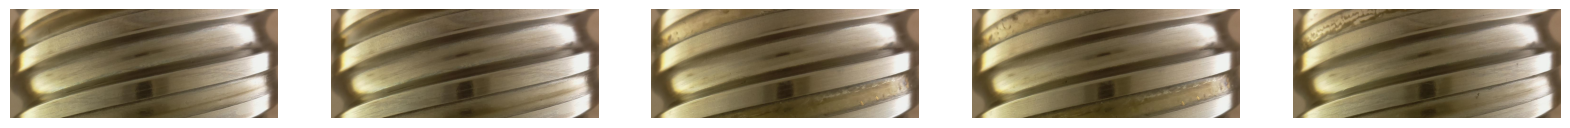

In [6]:
# train_filesの画像を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = cv2.imread(train_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

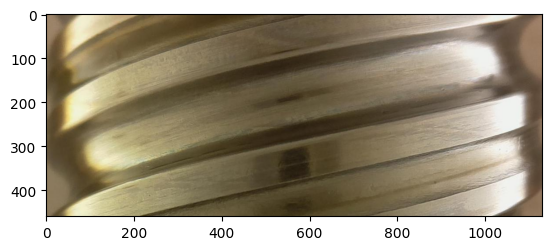

In [7]:
# reference:https://tanalib.com/labelme-json2image/

# jsonデータの読み込み
json_file = open(train_labels[0])
json_data = json.load(json_file)

# imageDataをkeyにしてデータを取り出す
img_b64 = json_data["imageData"]

# labelmeのutils関数を使ってbase64形式をPIL型に変換する
img_data = base64.b64decode(img_b64)
img_pil = utils.img_data_to_pil(img_data)

# 画像の可視化
plt.imshow(img_pil)
plt.show()

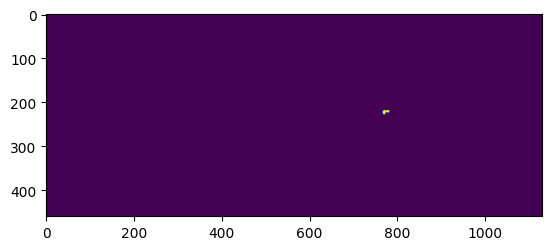

In [8]:
# reference:https://tanalib.com/labelme-json2image/

# アノテーションの頂点座標を取得
points = json_data["shapes"][0]["points"]  # 今回は画像中に1つだけ物体があることを想定
# list -> tuple
points = [tuple(point) for point in points]

# マスク画像を生成
w, h = img_pil.size
mask = Image.new("L", (w, h))
draw = ImageDraw.Draw(mask)
draw.polygon(points, fill=1)

# 画像の可視化
plt.imshow(mask)
plt.show()

In [9]:
# 上記をもとにして、画像とマスクを生成する関数を作成、画像中に複数の物体がある場合も考慮する
def create_mask_from_json(json_data, img_pil):
    # 画像サイズを取得
    w, h = img_pil.size
    # マスク画像を生成
    mask = Image.new("L", (w, h))
    draw = ImageDraw.Draw(mask)
    # マスク画像を生成するためのリスト
    mask_list = []
    # マスク画像を生成
    for shape in json_data["shapes"]:
        points = shape["points"]
        points = [tuple(point) for point in points]
        mask = Image.new("L", (w, h))
        draw = ImageDraw.Draw(mask)
        draw.polygon(points, fill=1)
        mask_list.append(mask)
    return mask_list

In [10]:
# train_labelsに対して上記の関数を適用
mask_list = []
img_paths = []

for label in train_labels:
    json_file = open(label)
    json_data = json.load(json_file)
    img_b64 = json_data["imageData"]

    # 画像パスを取得
    img_path = os.path.join(train_path, os.path.splitext(os.path.basename(label))[0] + '.jpg')
    img_paths.append(img_path)
    img_pil = utils.img_data_to_pil(base64.b64decode(img_b64))
    mask_list.append(create_mask_from_json(json_data, img_pil))

In [11]:
mask_list

[[<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image i

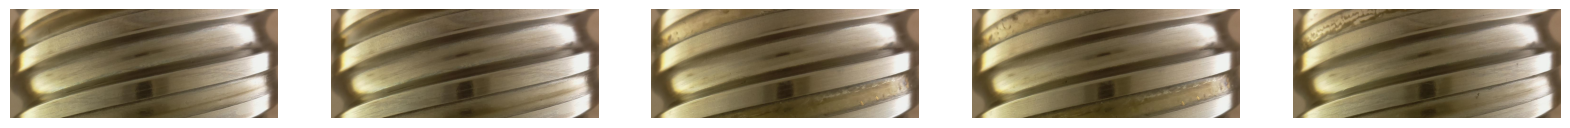

In [12]:
# img_pathsの画像を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(img_paths[i]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [13]:
img_paths

['../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200902053521_585000_090_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200902093536_585000_090_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200905041126_277500_315_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200905081130_277500_315_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200905081805_560000_000_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200905121127_277500_315_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200905121802_560000_000_crop_2.jpg',
 '../input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data/01_200905161132_277500_315_crop_2.jpg',
 '../input/10.35097-1278/10.3509

In [14]:
# mask_list[0]のshapeを確認
mask_list[0][0].size

(1130, 460)

In [15]:
# データセットクラスを作成
class SegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_list, transform=None):
        self.img_paths = img_paths
        self.mask_list = mask_list
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        mask = self.mask_list[idx][0]

        img = np.array(img)
        mask = np.array(mask)
        
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        return img, mask


# データセットを学習用とテスト用に分割
train_img_paths, val_img_paths, train_mask_list, val_mask_list = train_test_split(
    img_paths, mask_list, test_size=0.2, random_state=42
)

# 画像とマスクの前処理を定義、正規化はA.Normalize()を使用
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

val_transform = A.Compose([A.Resize(256, 256), A.Normalize(), ToTensorV2()])

# データセットを作成
train_dataset = SegmentationDataset(
    train_img_paths, train_mask_list, transform=train_transform
)
val_dataset = SegmentationDataset(val_img_paths, val_mask_list, transform=val_transform)

# データセットをDataLoaderに変換
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# モデルを定義
model = smp.Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(
    device
)

# 損失関数を定義
criterion = nn.BCEWithLogitsLoss()

# 最適化手法を定義
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
len(train_dataset)

315

In [17]:
len(val_dataset)

79

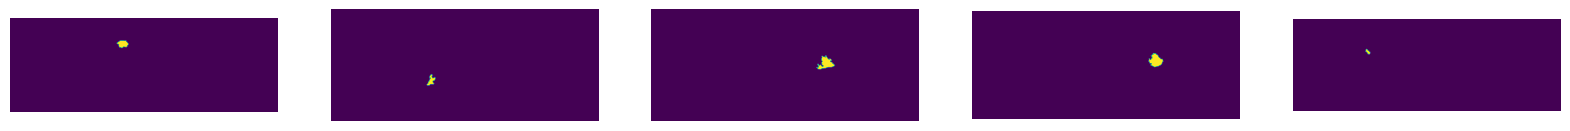

In [18]:
# train_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    mask = train_mask_list[i][0]
    plt.imshow(mask)
    plt.axis("off")
plt.show()

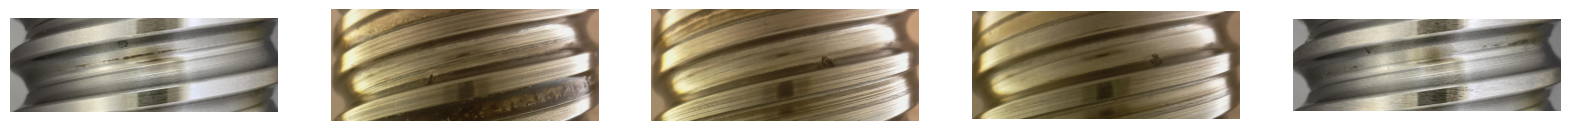

In [19]:
# train_img_pathsの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(train_img_paths[i]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
plt.show()

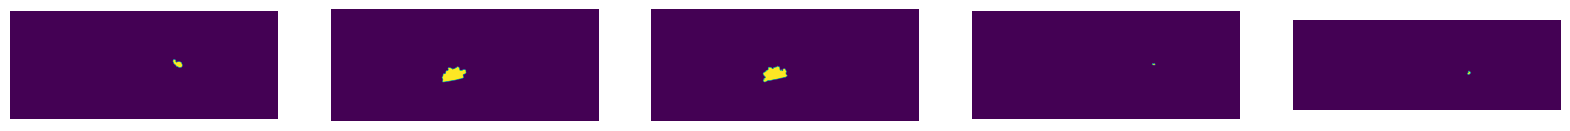

In [20]:
# val_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    mask = val_mask_list[i][0]
    plt.imshow(mask)
    plt.axis("off")
plt.show()

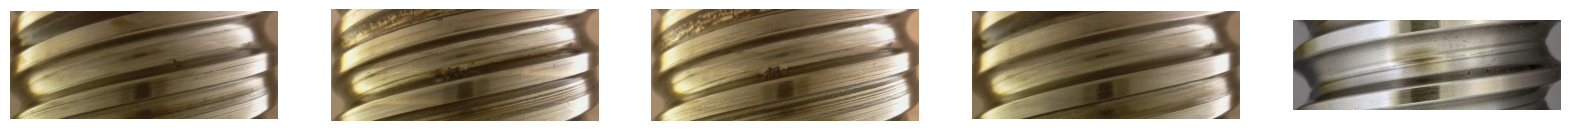

In [21]:
# val_img_pathsの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(val_img_paths[i]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
plt.show()

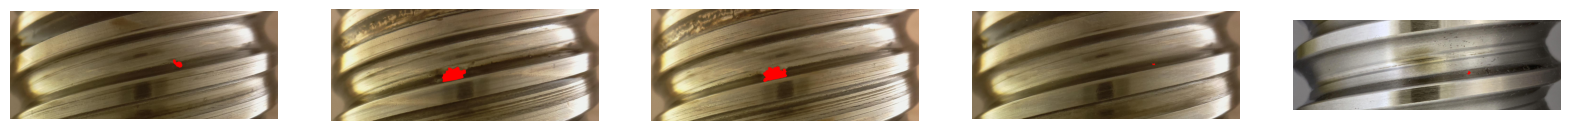

In [22]:
# val_img_paths, val_mask_listの画像とマスクを重ねて5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(val_img_paths[i]).convert("RGB")
    mask = val_mask_list[i][0]
    img = np.array(img)
    mask = np.array(mask)
    img[mask == 1] = [255, 0, 0]
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [23]:
# ベストモデル保存のための初期化
best_val_loss = float('inf')
save_path = '../output/image_segmentation_best_model.pth'

# 損失を記録するリスト
train_losses = []
val_losses = []

# テストデータは使用せずに学習
num_epochs = 100
scaler = GradScaler()

# スケジューラーを定義
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(x)
            y = y.unsqueeze(1).type(torch.float32)
            loss = criterion(outputs, y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    # Validation loop
    model.eval()
    val_epoch_loss = 0.0
    for batch in tqdm(val_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            outputs = model(x)
            y = y.unsqueeze(1).type(torch.float32)
            loss = criterion(outputs, y)
        
        val_epoch_loss += loss.item()
    
    val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}")
    
    # ベストモデルの保存
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")
    
    scheduler.step(val_loss)

print(f"Best validation loss: {best_val_loss:.4f}, Model saved to {save_path}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/100, Train Loss: 0.7561


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/100, Val Loss: 0.6114
Model saved at epoch 1 with validation loss 0.6114


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2/100, Train Loss: 0.5390


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/100, Val Loss: 0.5335
Model saved at epoch 2 with validation loss 0.5335


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3/100, Train Loss: 0.3843


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/100, Val Loss: 0.3157
Model saved at epoch 3 with validation loss 0.3157


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4/100, Train Loss: 0.2966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/100, Val Loss: 0.2468
Model saved at epoch 4 with validation loss 0.2468


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5/100, Train Loss: 0.2498


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/100, Val Loss: 0.2245
Model saved at epoch 5 with validation loss 0.2245


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6/100, Train Loss: 0.2160


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/100, Val Loss: 0.1976
Model saved at epoch 6 with validation loss 0.1976


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7/100, Train Loss: 0.1885


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/100, Val Loss: 0.1754
Model saved at epoch 7 with validation loss 0.1754


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8/100, Train Loss: 0.1645


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/100, Val Loss: 0.1555
Model saved at epoch 8 with validation loss 0.1555


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9/100, Train Loss: 0.1470


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/100, Val Loss: 0.1394
Model saved at epoch 9 with validation loss 0.1394


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10/100, Train Loss: 0.1315


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/100, Val Loss: 0.1195
Model saved at epoch 10 with validation loss 0.1195


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11/100, Train Loss: 0.1177


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/100, Val Loss: 0.1098
Model saved at epoch 11 with validation loss 0.1098


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12/100, Train Loss: 0.1063


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/100, Val Loss: 0.0994
Model saved at epoch 12 with validation loss 0.0994


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13/100, Train Loss: 0.0967


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/100, Val Loss: 0.0896
Model saved at epoch 13 with validation loss 0.0896


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14/100, Train Loss: 0.0884


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/100, Val Loss: 0.0842
Model saved at epoch 14 with validation loss 0.0842


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15/100, Train Loss: 0.0810


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/100, Val Loss: 0.0759
Model saved at epoch 15 with validation loss 0.0759


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16/100, Train Loss: 0.0744


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/100, Val Loss: 0.0699
Model saved at epoch 16 with validation loss 0.0699


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17/100, Train Loss: 0.0689


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/100, Val Loss: 0.0649
Model saved at epoch 17 with validation loss 0.0649


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18/100, Train Loss: 0.0636


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/100, Val Loss: 0.0593
Model saved at epoch 18 with validation loss 0.0593


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19/100, Train Loss: 0.0590


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/100, Val Loss: 0.0553
Model saved at epoch 19 with validation loss 0.0553


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20/100, Train Loss: 0.0551


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/100, Val Loss: 0.0519
Model saved at epoch 20 with validation loss 0.0519


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21/100, Train Loss: 0.0513


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21/100, Val Loss: 0.0480
Model saved at epoch 21 with validation loss 0.0480


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22/100, Train Loss: 0.0480


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22/100, Val Loss: 0.0454
Model saved at epoch 22 with validation loss 0.0454


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23/100, Train Loss: 0.0453


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23/100, Val Loss: 0.0423
Model saved at epoch 23 with validation loss 0.0423


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24/100, Train Loss: 0.0436


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24/100, Val Loss: 0.0412
Model saved at epoch 24 with validation loss 0.0412


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25/100, Train Loss: 0.0403


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25/100, Val Loss: 0.0373
Model saved at epoch 25 with validation loss 0.0373


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26/100, Train Loss: 0.0375


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26/100, Val Loss: 0.0357
Model saved at epoch 26 with validation loss 0.0357


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27/100, Train Loss: 0.0356


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27/100, Val Loss: 0.0333
Model saved at epoch 27 with validation loss 0.0333


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28/100, Train Loss: 0.0335


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28/100, Val Loss: 0.0316
Model saved at epoch 28 with validation loss 0.0316


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29/100, Train Loss: 0.0316


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29/100, Val Loss: 0.0299
Model saved at epoch 29 with validation loss 0.0299


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30/100, Train Loss: 0.0298


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30/100, Val Loss: 0.0283
Model saved at epoch 30 with validation loss 0.0283


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 31/100, Train Loss: 0.0282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 31/100, Val Loss: 0.0264
Model saved at epoch 31 with validation loss 0.0264


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 32/100, Train Loss: 0.0267


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32/100, Val Loss: 0.0253
Model saved at epoch 32 with validation loss 0.0253


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 33/100, Train Loss: 0.0253


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 33/100, Val Loss: 0.0238
Model saved at epoch 33 with validation loss 0.0238


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 34/100, Train Loss: 0.0239


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 34/100, Val Loss: 0.0225
Model saved at epoch 34 with validation loss 0.0225


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 35/100, Train Loss: 0.0228


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 35/100, Val Loss: 0.0215
Model saved at epoch 35 with validation loss 0.0215


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 36/100, Train Loss: 0.0215


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 36/100, Val Loss: 0.0204
Model saved at epoch 36 with validation loss 0.0204


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 37/100, Train Loss: 0.0206


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 37/100, Val Loss: 0.0195
Model saved at epoch 37 with validation loss 0.0195


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 38/100, Train Loss: 0.0196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38/100, Val Loss: 0.0181
Model saved at epoch 38 with validation loss 0.0181


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 39/100, Train Loss: 0.0183


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 39/100, Val Loss: 0.0174
Model saved at epoch 39 with validation loss 0.0174


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 40/100, Train Loss: 0.0175


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 40/100, Val Loss: 0.0165
Model saved at epoch 40 with validation loss 0.0165


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 41/100, Train Loss: 0.0168


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 41/100, Val Loss: 0.0161
Model saved at epoch 41 with validation loss 0.0161


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 42/100, Train Loss: 0.0160


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 42/100, Val Loss: 0.0151
Model saved at epoch 42 with validation loss 0.0151


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 43/100, Train Loss: 0.0153


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 43/100, Val Loss: 0.0145
Model saved at epoch 43 with validation loss 0.0145


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 44/100, Train Loss: 0.0146


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 44/100, Val Loss: 0.0138
Model saved at epoch 44 with validation loss 0.0138


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 45/100, Train Loss: 0.0143


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 45/100, Val Loss: 0.0132
Model saved at epoch 45 with validation loss 0.0132


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 46/100, Train Loss: 0.0135


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 46/100, Val Loss: 0.0131
Model saved at epoch 46 with validation loss 0.0131


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 47/100, Train Loss: 0.0130


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 47/100, Val Loss: 0.0124
Model saved at epoch 47 with validation loss 0.0124


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 48/100, Train Loss: 0.0127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 48/100, Val Loss: 0.0119
Model saved at epoch 48 with validation loss 0.0119


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 49/100, Train Loss: 0.0121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 49/100, Val Loss: 0.0114
Model saved at epoch 49 with validation loss 0.0114


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 50/100, Train Loss: 0.0116


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 50/100, Val Loss: 0.0112
Model saved at epoch 50 with validation loss 0.0112


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 51/100, Train Loss: 0.0111


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 51/100, Val Loss: 0.0108
Model saved at epoch 51 with validation loss 0.0108


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 52/100, Train Loss: 0.0109


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 52/100, Val Loss: 0.0103
Model saved at epoch 52 with validation loss 0.0103


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 53/100, Train Loss: 0.0104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 53/100, Val Loss: 0.0099
Model saved at epoch 53 with validation loss 0.0099


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 54/100, Train Loss: 0.0101


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 54/100, Val Loss: 0.0096
Model saved at epoch 54 with validation loss 0.0096


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 55/100, Train Loss: 0.0098


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 55/100, Val Loss: 0.0092
Model saved at epoch 55 with validation loss 0.0092


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 56/100, Train Loss: 0.0096


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 56/100, Val Loss: 0.0091
Model saved at epoch 56 with validation loss 0.0091


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 57/100, Train Loss: 0.0092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 57/100, Val Loss: 0.0087
Model saved at epoch 57 with validation loss 0.0087


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 58/100, Train Loss: 0.0090


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 58/100, Val Loss: 0.0084
Model saved at epoch 58 with validation loss 0.0084


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 59/100, Train Loss: 0.0087


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 59/100, Val Loss: 0.0082
Model saved at epoch 59 with validation loss 0.0082


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 60/100, Train Loss: 0.0084


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 60/100, Val Loss: 0.0080
Model saved at epoch 60 with validation loss 0.0080


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 61/100, Train Loss: 0.0081


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 61/100, Val Loss: 0.0079
Model saved at epoch 61 with validation loss 0.0079


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 62/100, Train Loss: 0.0080


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 62/100, Val Loss: 0.0074
Model saved at epoch 62 with validation loss 0.0074


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 63/100, Train Loss: 0.0077


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 63/100, Val Loss: 0.0074


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 64/100, Train Loss: 0.0074


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 64/100, Val Loss: 0.0073
Model saved at epoch 64 with validation loss 0.0073


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 65/100, Train Loss: 0.0075


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 65/100, Val Loss: 0.0071
Model saved at epoch 65 with validation loss 0.0071


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 66/100, Train Loss: 0.0071


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 66/100, Val Loss: 0.0067
Model saved at epoch 66 with validation loss 0.0067


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 67/100, Train Loss: 0.0070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 67/100, Val Loss: 0.0066
Model saved at epoch 67 with validation loss 0.0066


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 68/100, Train Loss: 0.0068


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 68/100, Val Loss: 0.0065
Model saved at epoch 68 with validation loss 0.0065


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 69/100, Train Loss: 0.0066


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 69/100, Val Loss: 0.0065


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 70/100, Train Loss: 0.0065


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 70/100, Val Loss: 0.0061
Model saved at epoch 70 with validation loss 0.0061


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 71/100, Train Loss: 0.0063


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 71/100, Val Loss: 0.0060
Model saved at epoch 71 with validation loss 0.0060


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 72/100, Train Loss: 0.0062


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 72/100, Val Loss: 0.0059
Model saved at epoch 72 with validation loss 0.0059


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 73/100, Train Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 73/100, Val Loss: 0.0058
Model saved at epoch 73 with validation loss 0.0058


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 74/100, Train Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 74/100, Val Loss: 0.0057
Model saved at epoch 74 with validation loss 0.0057


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 75/100, Train Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 75/100, Val Loss: 0.0055
Model saved at epoch 75 with validation loss 0.0055


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 76/100, Train Loss: 0.0058


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 76/100, Val Loss: 0.0055


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 77/100, Train Loss: 0.0056


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 77/100, Val Loss: 0.0052
Model saved at epoch 77 with validation loss 0.0052


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 78/100, Train Loss: 0.0054


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 78/100, Val Loss: 0.0051
Model saved at epoch 78 with validation loss 0.0051


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 79/100, Train Loss: 0.0053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 79/100, Val Loss: 0.0051
Model saved at epoch 79 with validation loss 0.0051


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 80/100, Train Loss: 0.0053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 80/100, Val Loss: 0.0049
Model saved at epoch 80 with validation loss 0.0049


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 81/100, Train Loss: 0.0051


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 81/100, Val Loss: 0.0050


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 82/100, Train Loss: 0.0050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 82/100, Val Loss: 0.0047
Model saved at epoch 82 with validation loss 0.0047


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 83/100, Train Loss: 0.0050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 83/100, Val Loss: 0.0047
Model saved at epoch 83 with validation loss 0.0047


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 84/100, Train Loss: 0.0050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 84/100, Val Loss: 0.0045
Model saved at epoch 84 with validation loss 0.0045


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 85/100, Train Loss: 0.0048


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 85/100, Val Loss: 0.0047


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 86/100, Train Loss: 0.0047


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 86/100, Val Loss: 0.0044
Model saved at epoch 86 with validation loss 0.0044


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 87/100, Train Loss: 0.0046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 87/100, Val Loss: 0.0043
Model saved at epoch 87 with validation loss 0.0043


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 88/100, Train Loss: 0.0045


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 88/100, Val Loss: 0.0044


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 89/100, Train Loss: 0.0045


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 89/100, Val Loss: 0.0042
Model saved at epoch 89 with validation loss 0.0042


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 90/100, Train Loss: 0.0043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 90/100, Val Loss: 0.0042


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 91/100, Train Loss: 0.0043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 91/100, Val Loss: 0.0042


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 92/100, Train Loss: 0.0042


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 92/100, Val Loss: 0.0040
Model saved at epoch 92 with validation loss 0.0040


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 93/100, Train Loss: 0.0041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 93/100, Val Loss: 0.0040


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 94/100, Train Loss: 0.0041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 94/100, Val Loss: 0.0040
Model saved at epoch 94 with validation loss 0.0040


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 95/100, Train Loss: 0.0040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 95/100, Val Loss: 0.0037
Model saved at epoch 95 with validation loss 0.0037


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 96/100, Train Loss: 0.0040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 96/100, Val Loss: 0.0039


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 97/100, Train Loss: 0.0039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 97/100, Val Loss: 0.0037
Model saved at epoch 97 with validation loss 0.0037


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 98/100, Train Loss: 0.0039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 98/100, Val Loss: 0.0037


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 99/100, Train Loss: 0.0039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 99/100, Val Loss: 0.0036
Model saved at epoch 99 with validation loss 0.0036


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100/100, Train Loss: 0.0039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100/100, Val Loss: 0.0036
Model saved at epoch 100 with validation loss 0.0036
Best validation loss: 0.0036, Model saved to ../output/image_segmentation_best_model.pth


  0%|          | 0/10 [00:00<?, ?it/s]

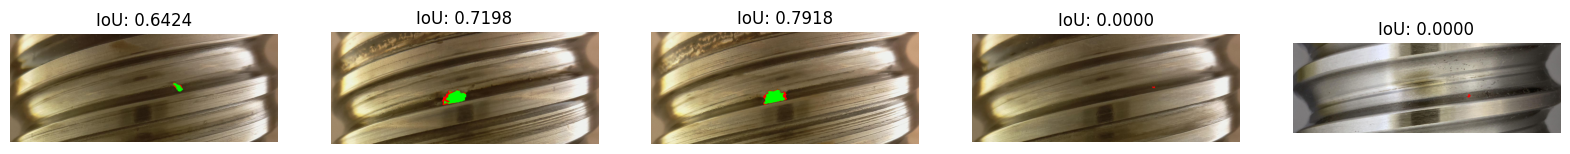

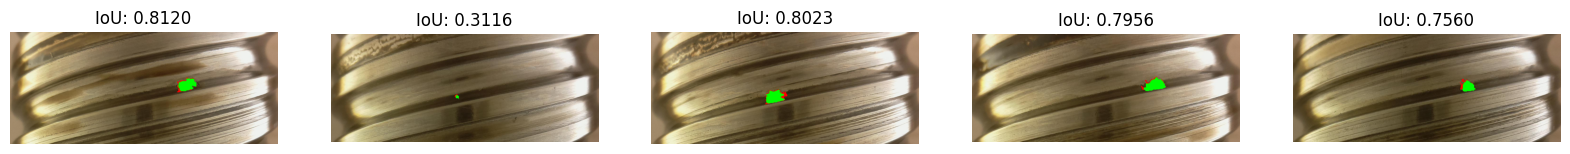

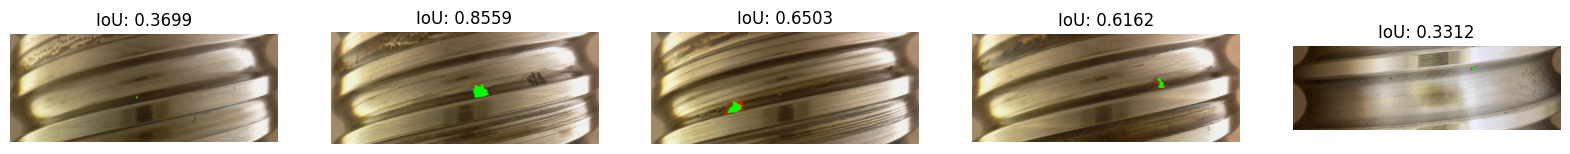

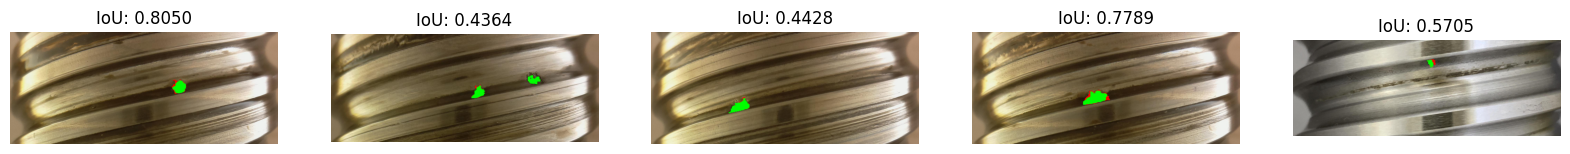

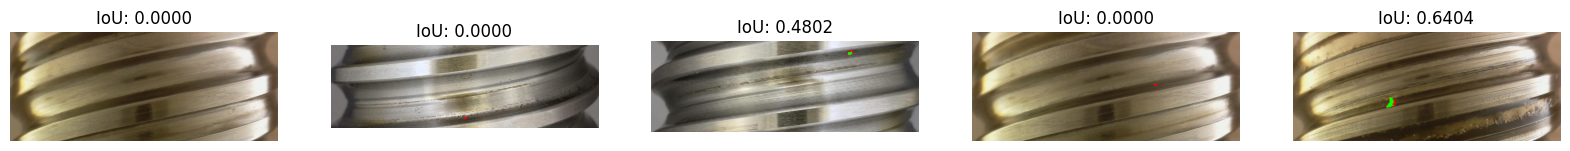

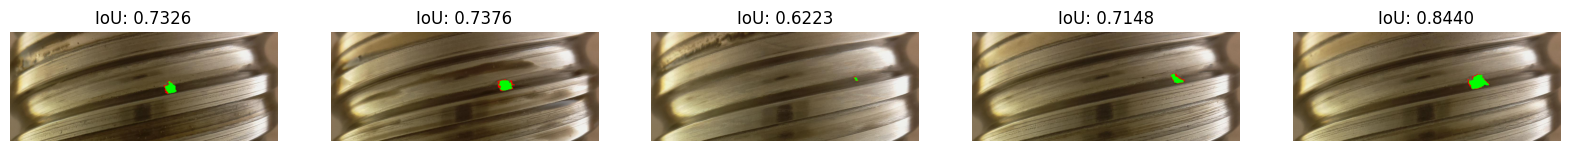

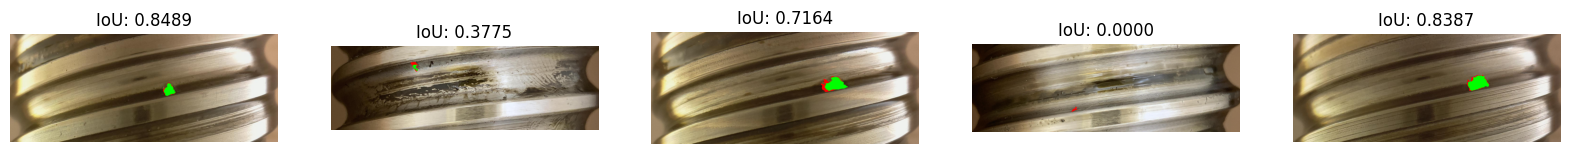

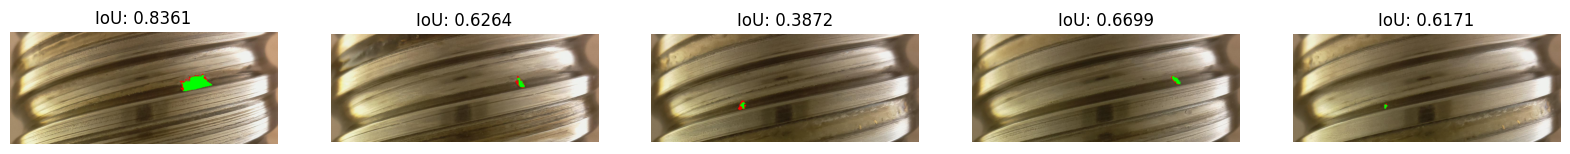

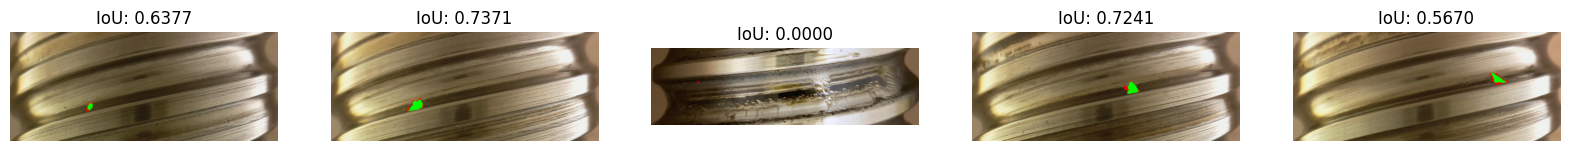

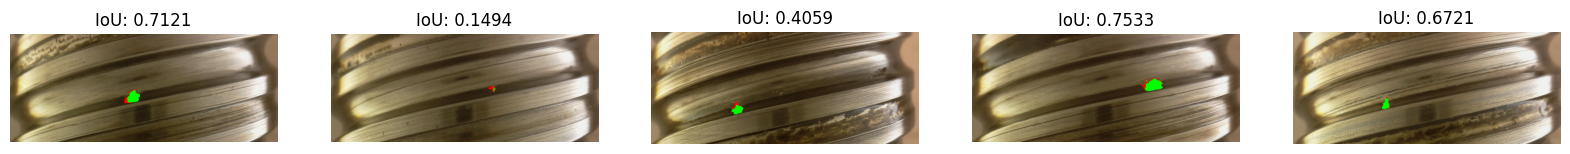

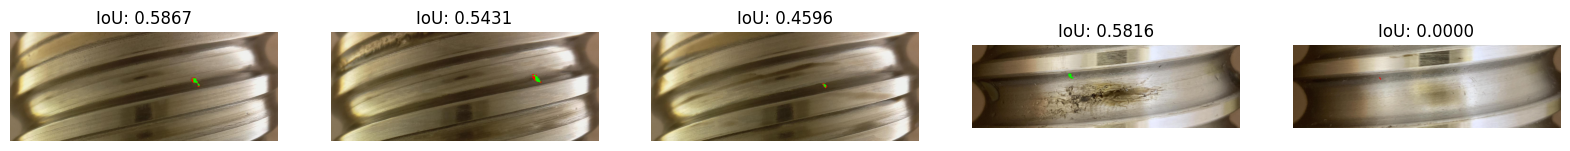

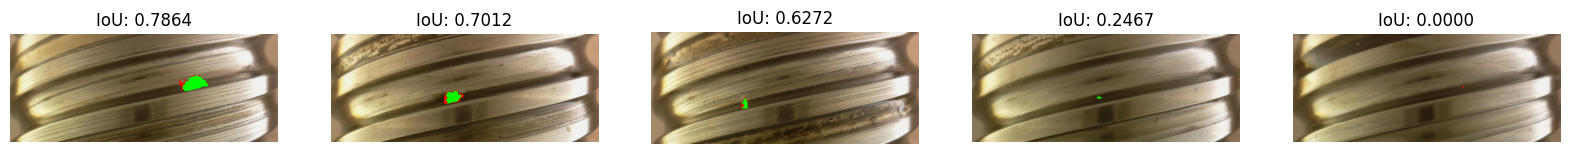

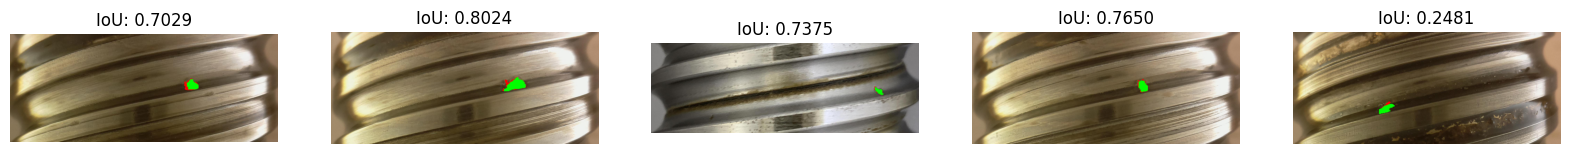

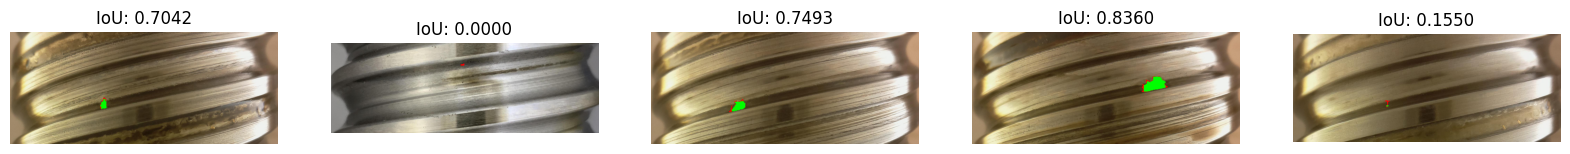

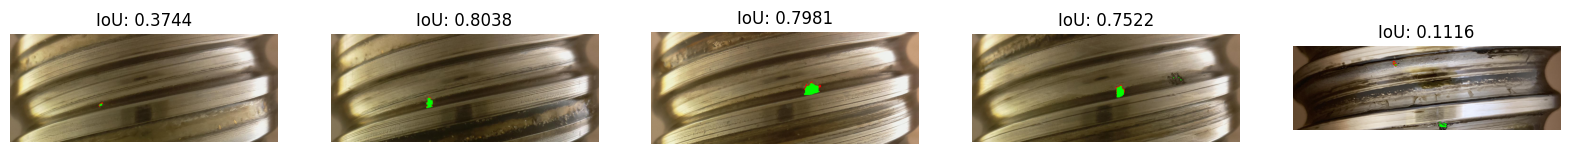

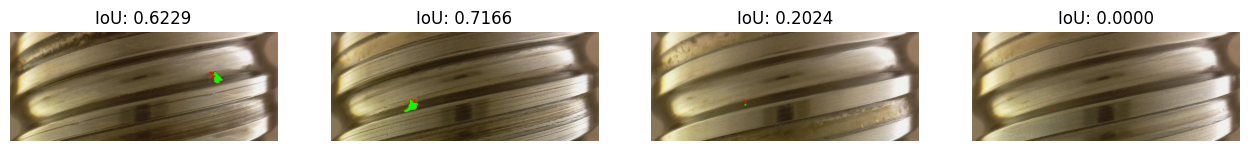

In [24]:
# モデルの評価モード
model.eval()
outputs_list = []

# val_loader からのデータに対してモデルの予測を収集
for img, mask in tqdm(val_loader):
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
    outputs_list.extend(outputs.cpu().numpy())

iou_list = []

# 5枚ごとに分割して表示
num_images = len(val_img_paths)
num_batches = (num_images + 4) // 5  # 5枚ずつ分割したときのバッチ数

for batch_idx in range(num_batches):
    start_idx = batch_idx * 5
    end_idx = min(start_idx + 5, num_images)
    plt.figure(figsize=(20, 10))
    for i in range(start_idx, end_idx):
        plt.subplot(1, 5, i - start_idx + 1)
        img = Image.open(val_img_paths[i]).convert("RGB")
        mask = val_mask_list[i][0]
        
        # imgとmaskをNumPy配列に変換
        img = np.array(img)
        mask = np.array(mask)
        
        # マスクされた部分を赤色にする
        img[mask == 1] = [255, 0, 0]
        
        # モデルからの予測結果を取得
        pred = outputs_list[i]
        pred = np.squeeze(pred)  # バッチ次元を除く
        if pred.ndim == 3:
            pred = pred[0]  # チャネル次元を除く（最初のチャネルを使用）
        
        # predをimgのサイズにリサイズする
        pred_resized = cv2.resize(
            pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST
        )
        
        # 予測マスクを元の画像に適用
        img[pred_resized > 0.5] = [0, 255, 0]  # 予測された部分を緑色で表示
        
        # IoUの計算
        mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        pred_resized = pred_resized > 0.5
        mask_resized = mask_resized > 0.5
        intersection = np.logical_and(pred_resized, mask_resized)
        union = np.logical_or(pred_resized, mask_resized)
        iou = np.sum(intersection) / np.sum(union)
        iou_list.append(iou)

        plt.imshow(img)
        plt.title(f'IoU: {iou:.4f}')
        plt.axis("off")

    plt.show()

In [25]:
# IoUの平均値を計算
iou_mean = np.mean(iou_list)
print(f"Mean IoU: {iou_mean:.4f}")

Mean IoU: 0.5336


In [26]:
# IoU=0の水準を除いてIoUの平均値を計算
iou_mean = np.mean([iou for iou in iou_list if iou > 0])
print(f"Mean IoU (IoU=0 excluded): {iou_mean:.4f}")

Mean IoU (IoU=0 excluded): 0.6199


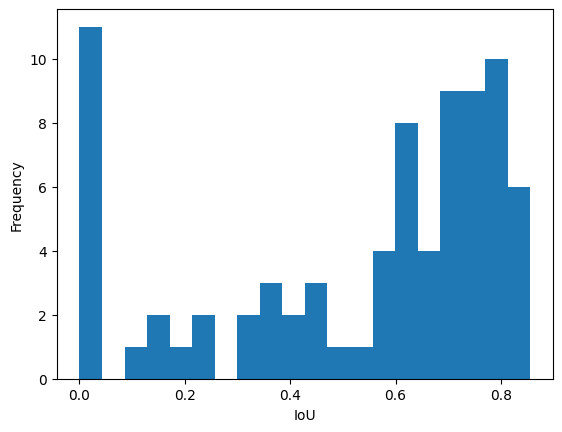

In [27]:
# IoUの分布を表示
plt.hist(iou_list, bins=20)
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.show()

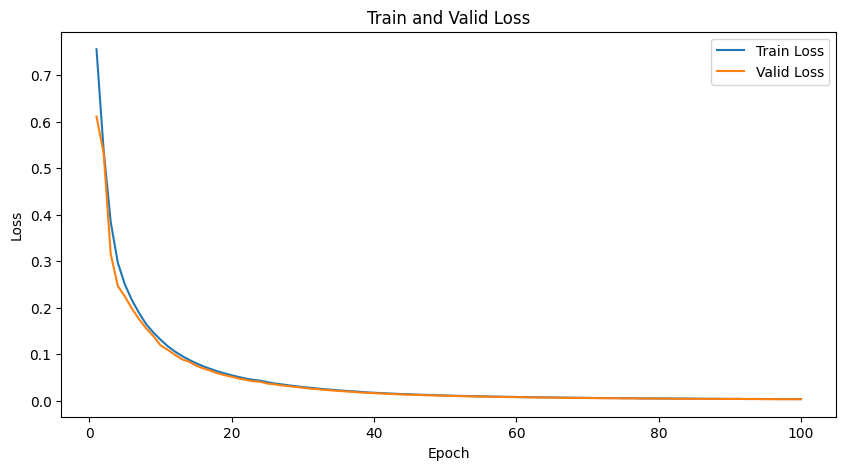

In [28]:
# 損失の推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Loss')
plt.legend()
plt.show()